# Descripción del Código

Este código implementa un modelo de detección de fraudes en transacciones financieras utilizando **Autoencoders** en TensorFlow/Keras. El codigo fue generado con la asistencia de Chat GPT.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


1. **Generación de Datos Sintéticos**
   - Se simulan transacciones financieras con montos, tiempo y categorías aleatorias.
   - Se introduce un 2% de transacciones fraudulentas.

In [2]:
np.random.seed(42)
n_samples = 10000

data = {
    'amount': np.random.exponential(scale=50, size=n_samples),  # Monto de la transacción
    'time': np.random.randint(0, 86400, size=n_samples),  # Hora del día en segundos
    'category': np.random.randint(1, 10, size=n_samples),  # Categoría de gasto
    'is_fraud': np.random.choice([0, 1], size=n_samples, p=[0.98, 0.02])  # 2% de fraude
}
df = pd.DataFrame(data)

2. **Preprocesamiento**
   - Se normalizan los datos con `StandardScaler`.
   - Se dividen en conjuntos de entrenamiento y prueba.
   - Se seleccionan únicamente transacciones normales para el entrenamiento del Autoencoder.

In [3]:
# Normalización de datos
scaler = StandardScaler()
x = df[['amount', 'time', 'category']]
x_scaled = scaler.fit_transform(x)

# Separar datos normales y fraudulentos
x_train, x_test, y_train, y_test = train_test_split(x_scaled, df['is_fraud'], test_size=0.2, random_state=42)
x_train_normal = x_train[y_train == 0]  # Solo datos normales para entrenamiento

3. **Creación del Autoencoder**
   - Se construye un modelo con una arquitectura de tres capas en el codificador y tres en el decodificador.
   - Se entrena el modelo para que aprenda a reconstruir datos normales.

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.8863 - val_loss: 0.5619
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4198 - val_loss: 0.1049
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0598 - val_loss: 0.0122
Epoch 4/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0103 - val_loss: 0.0046
Epoch 5/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044 - val_loss: 0.0027
Epoch 6/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 7/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 8/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 9/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - val_loss: 8.6493e-04
Epoch 10/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.1791e-04 - val_loss: 5.8264e-04
Epoch 11/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7861e-04 - val_loss: 4.4348e-04
Epoch 12/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s

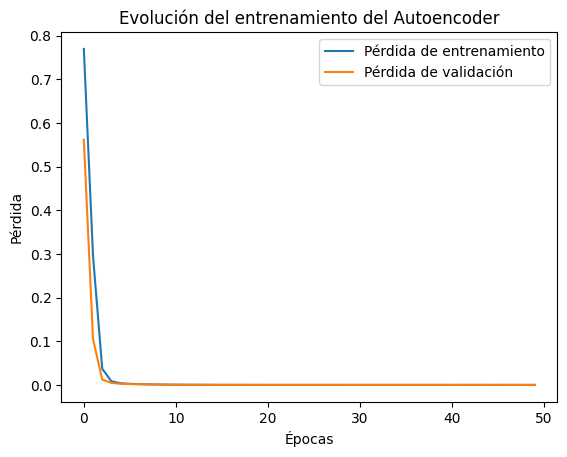

In [8]:
# Definir Autoencoder
input_dim = x_train_normal.shape[1]

encoder = keras.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(input_dim,)),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(4, activation='relu')
])

decoder = keras.Sequential([
    keras.layers.Dense(8, activation='relu', input_shape=(4,)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(input_dim, activation='linear')
])

autoencoder = keras.Sequential([encoder, decoder])
autoencoder.compile(optimizer='adam', loss='mse')

# Entrenar el modelo solo con transacciones normales
history = autoencoder.fit(x_train_normal, x_train_normal, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# Visualizar la evolución del entrenamiento
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Evolución del entrenamiento del Autoencoder')
plt.show()

4. **Detección de Fraudes**
   - Se calcula el error cuadrático medio (MSE) en la reconstrucción de las transacciones de prueba.
   - Se establece un umbral para clasificar anomalías basado en el percentil 95.

In [5]:
# Evaluar errores de reconstrucción
x_test_pred = autoencoder.predict(x_test)
mse = np.mean(np.power(x_test - x_test_pred, 2), axis=1)

# Determinar umbral de anomalía
threshold = np.percentile(mse, 95)  # Consideramos anomalías en el 5% más alto

y_pred = mse > threshold


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


5. **Evaluación del Modelo**
   - **Precisión (Precision)**: Mide qué proporción de las transacciones detectadas como fraudulentas realmente lo son. Se calcula como `TP / (TP + FP)`, donde:
     - `TP` (Verdaderos Positivos) son fraudes correctamente detectados.
     - `FP` (Falsos Positivos) son transacciones normales clasificadas erróneamente como fraudes.
   
   - **Exhaustividad o Sensibilidad (Recall)**: Indica qué proporción de todas las transacciones fraudulentas fueron detectadas. Se calcula como `TP / (TP + FN)`, donde:
     - `FN` (Falsos Negativos) son fraudes que el modelo no detectó.
   
   - **Puntaje F1 (F1-score)**: Es la media armónica entre precisión y recall, proporcionando un equilibrio entre ambas métricas. Se calcula como `2 * (Precision * Recall) / (Precision + Recall)`.
   
   - **Exactitud (Accuracy)**: Mide la proporción de transacciones correctamente clasificadas en general.
   
   - Se genera un informe detallado con estas métricas utilizando `classification_report` de `sklearn`.

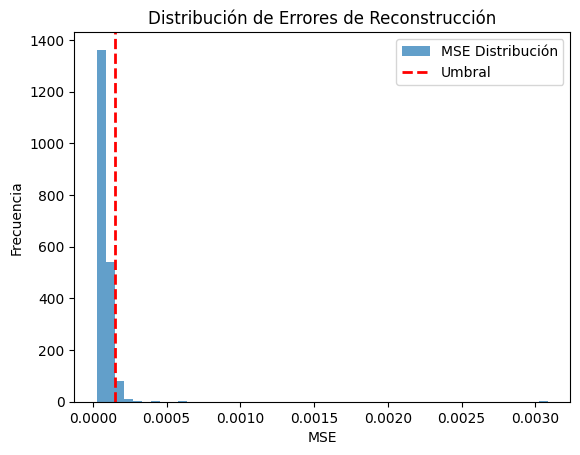

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1952
           1       0.02      0.04      0.03        48

    accuracy                           0.93      2000
   macro avg       0.50      0.50      0.49      2000
weighted avg       0.95      0.93      0.94      2000



In [9]:
# Visualización de los errores de reconstrucción
plt.hist(mse, bins=50, alpha=0.7, label='MSE Distribución')
plt.axvline(threshold, color='r', linestyle='dashed', linewidth=2, label='Umbral')
plt.legend()
plt.xlabel('MSE')
plt.ylabel('Frecuencia')
plt.title('Distribución de Errores de Reconstrucción')
plt.show()

# Resultados
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
